In [97]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm.notebook import tqdm
from torchvision import models
from PIL import Image

# Set random seed for reproducibility
manualSeed = 777
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  777


In [2]:
#check cuda working
print(torch.cuda.is_available())

True


# Hyperparameters

In [16]:
# Root directory for dataset
dataroot = "../data/cryptopunks/imgs/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 16

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 24

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1

# Learning rate for optimizers
#lr = 0.0001
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [100]:
test = Image.open((dataroot +'/imgs/1.png'))
print(test)

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=24x24 at 0x2279BBA7F10>


# Data 

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))

<Figure size 432x288 with 0 Axes>

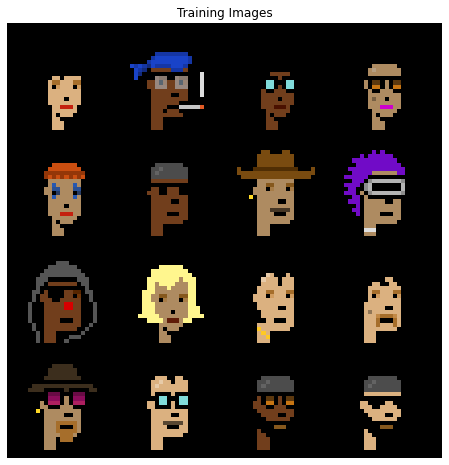

In [96]:
plt.gcf().set_facecolor('white')
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

# Generator & Discriminator Init

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

### Custom Architecture

In [6]:
# Generator Code

class Generator(nn.Module):  
     # Network Initialisation
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d( nz, ngf, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 128  x 6 x 6

            nn.ConvTranspose2d( ngf, ngf, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 128 x 12 x 12

            nn.ConvTranspose2d( ngf, ngf, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 128 x 24 x 24

            nn.ConvTranspose2d( ngf, nc, 4, 1, 1, bias=False),
            nn.Tanh()
            # 3 x 24 x 24
        )

    def forward(self, input):
        return self.main(input)

### Prebuilt Archictecture


### Inititialisation

In [7]:
# Create the generator
netG = Generator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


## Discriminator

### Default Net

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 24 x 24
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 12 x 12

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 6 x 6

            nn.Conv2d(ndf*2, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),

        )

    def forward(self, input):
        output = nn.parallel.data_parallel(self.main, input)
        return output.view(-1, 1)

### Alternative Architecture

In [9]:
class AltDis(nn.Module):
    
    # Network Initialisation
    def __init__(self):
        
        super(AltDis, self).__init__()
           
        # Convolution Layers
        # 24 x 24
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 0)
        # 12 x 12
        self.conv2 = nn.Conv2d(ndf, ndf, 4, 2, 0)
        # 6 x 6

        # compute the flatten size
        self.fc1 = nn.Linear(64*4*4, 100)
        self.fc2 = nn.Linear(100, 1)

        
    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.leaky_relu(self.conv1(X), 0.02)
        X = F.leaky_relu(self.conv2(X), 0.02)
       
        X = X.view(-1, 64*4*4)
        
        X = F.leaky_relu(self.fc1(X), 0.02)
        X = F.dropout(X, 0.1)
        X = self.fc2(X)
        
        return F.sigmoid(X)


### Initialisation

In [10]:
# Create the Discriminator
#netD = Discriminator(ngpu).to(device)
netD = AltDis().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

AltDis(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


# Training

## Loss function and optimiser

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Main Loop

In [21]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        #data[0] - x ; data[1] - y

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        
        #print(output,label)
        
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)

        #print(fake.size())

        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        '''
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        '''

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, nrow=5, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\wvdm2\anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Results

## Loss

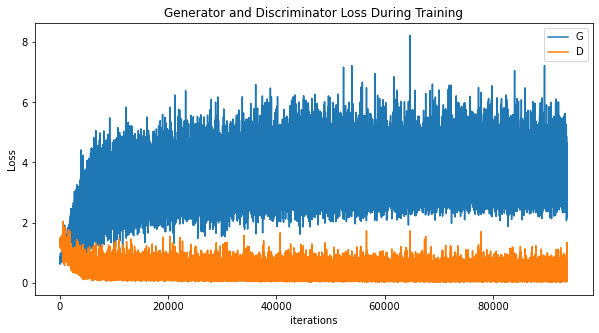

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Sample images

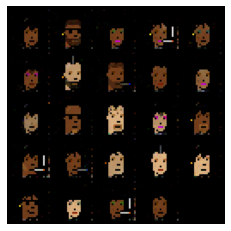

In [22]:
#%%capture
fig = plt.figure(figsize=(4,4))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Compared Images 

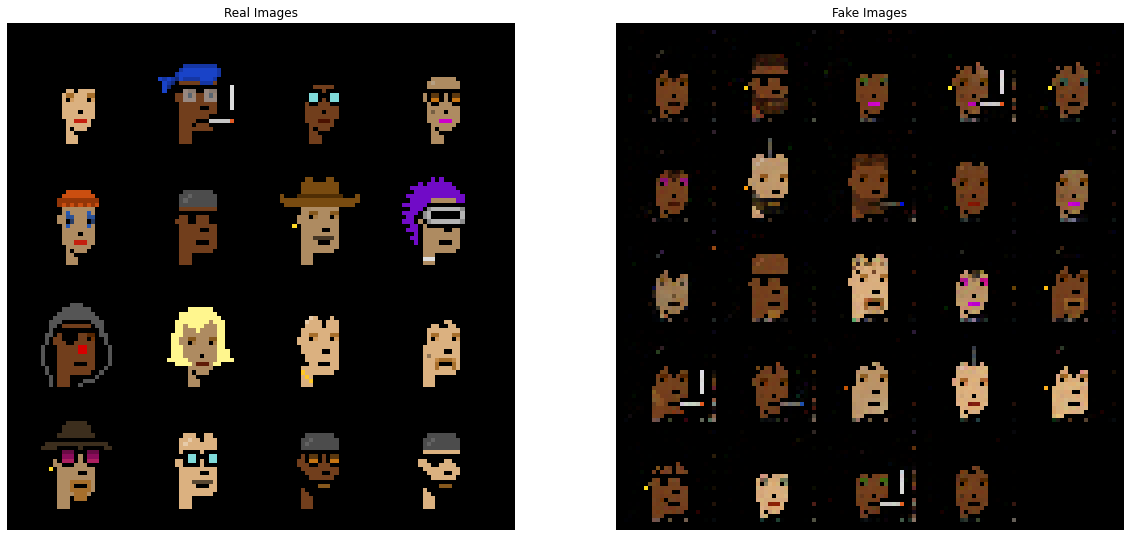

In [23]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], nrow=4, padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Simulate input

torch.Size([1, 64])
torch.Size([24, 64, 1, 1])


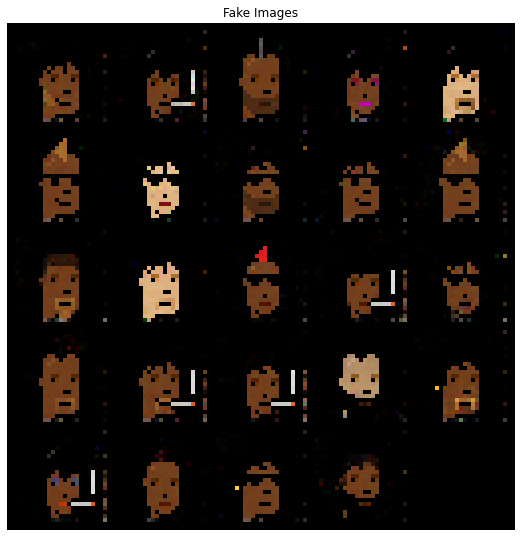

In [101]:
# Plot the fake images from the last epoch
fixed_noise = torch.linspace(0, 1, 64, device=device)
print(torch.unsqueeze(fixed_noise, -2).size())

fixed_noise = torch.randn(image_size, nz, 1, 1, device=device)
print(fixed_noise.size())

with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, nrow=5, padding=2, normalize=True))


plt.figure(figsize=(20,20))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.gcf().set_facecolor('white')
plt.show()